# Cats & Dogs Twitter Network Analysis

## Importing libraries

In [98]:
import networkx as nx
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.tokenize import TweetTokenizer
import re

nltk.download('stopwords')

## Importing Data

In [2]:
g_cats = nx.read_gml('graph_tweet_cats.gml.gz') 
g_dogs = nx.read_gml('graph_tweet_dogs.gml.gz') 

## Statistical Analysis

### Overall Network Statistics

In [55]:
def compute_statistics(g):
  n_nodes = len(g)
  n_edges = len(g.edges)
  density = nx.classes.function.density(g)
  edges_per_node = n_edges/n_nodes
  connected_components = nx.number_connected_components( g.to_undirected(reciprocal=False) )
  dict_r = { "nodes":n_nodes, "edges":n_edges, "density":density,
             "edges p/ node":edges_per_node, 
             "connected components":connected_components }
  return dict_r

In [57]:
stats = { 'cats':compute_statistics(g_cats), 'dogs':compute_statistics(g_dogs) }
pd.DataFrame.from_dict(stats, orient='index')

,nodes,edges,density,edges p/ node,connected components
cats,21668,18274,0.000039,0.843363,3394
dogs,23456,20375,0.000037,0.868648,3081


### Analyzing degrees

**Creating DataFrames**

In [90]:
graph_to_nodes_df = lambda g: pd.DataFrame.from_dict( data=dict(g.nodes(data=True)), orient='index' )

df_cats = graph_to_nodes_df(g_cats)
df_dogs = graph_to_nodes_df(g_dogs)

**Adding columns with degree info**

In [88]:
def add_colum_from_tuple_list( df, tl, name ):
  df_tuples = pd.DataFrame( data=list(tl), columns=['index', name])
  df = df.merge(df_tuples, how='inner', on='index')
  return df

In [91]:
df_cats = add_colum_from_tuple_list( df_cats.reset_index(), g_cats.in_degree, 'in degree' )
df_cats = add_colum_from_tuple_list( df_cats, g_cats.out_degree, 'out degree' )

df_dogs = add_colum_from_tuple_list( df_dogs.reset_index(), g_dogs.in_degree, 'in degree' )
df_dogs = add_colum_from_tuple_list( df_dogs, g_dogs.out_degree, 'out degree' )

**Visualizing in degree distribution**

In [95]:
in_deg_gt_0_func = lambda value: 'in degree > 0' if value>0 else 'in degree = 0'

df_cats['animal'] = 'cat'
df_dogs['animal'] = 'dog'
df_cats['in_deg_gt_0'] = df_cats['in degree'].apply(in_deg_gt_0_func)
df_dogs['in_deg_gt_0'] = df_dogs['in degree'].apply(in_deg_gt_0_func)

full_df = pd.concat( [df_cats, df_dogs] )

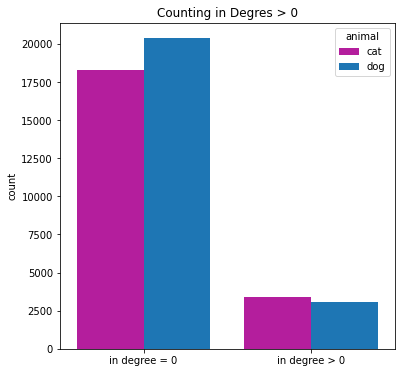

In [119]:
fig, ax = plt.subplots( figsize=(6,6) )
animal_palette = {'cat':'#cd05ae', 'dog':'#057acd'}

sns.countplot(data=full_df, x='in_deg_gt_0', hue = 'animal', 
              palette=animal_palette, 
              ax=ax)
ax.set_title("Counting in Degres > 0")
ax.set_xlabel('')
fig.show()

**Out Degree Behaviour**

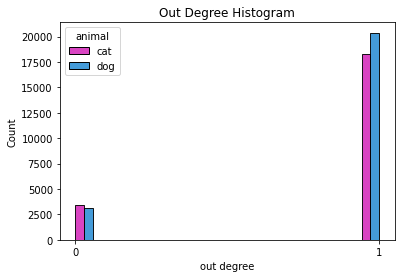

In [145]:
fig, ax = plt.subplots()
sns.histplot(data=full_df, x='out degree', hue='animal', 
             multiple='dodge',
             palette=animal_palette, ax=ax )
ax.set_title('Out Degree Histogram')
ax.set_xticks( [0,1] )
fig.show()

**Correlation between In Degree and Likes**

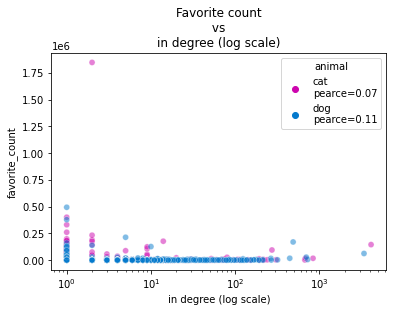

In [192]:
full_df_indeg_favcou = full_df.query( "in_deg_gt_0 == 'in degree > 0'" )[ ['in degree', 'favorite_count', 'animal'] ]
fig, ax = plt.subplots()

## Calculating pearce coefficient
dog_pearce = full_df_indeg_favcou.query( "animal == 'dog'" ).corr()['favorite_count']['in degree']
cat_pearce = full_df_indeg_favcou.query( "animal == 'cat'" ).corr()['favorite_count']['in degree']

name_pearce = lambda s: f"{s}\npearce={cat_pearce.round(2)}" if s=='cat' else f"{s}\npearce={dog_pearce.round(2)}"
full_df_indeg_favcou['animal'] = full_df_indeg_favcou['animal'].apply( name_pearce )

animal_palette_pearce = {f'cat\npearce={cat_pearce.round(2)}':'#cd05ae', 
                         f'dog\npearce={dog_pearce.round(2)}':'#057acd'}

ax.set_xscale('log')
ax.set_xlabel( 'in degree (log scale)' )
ax.set_title( 'Favorite count\n vs \nin degree (log scale)' )

sns.scatterplot(data=full_df_indeg_favcou,
                hue='animal', x='in degree', y='favorite_count',
                alpha=0.5, palette=animal_palette_pearce,
                ax=ax)

## NLP analysis

### Text Normalization

In [246]:
strip_punctuation = lambda s: re.sub(r'[^\w\s#\']','',s)
strip_numbers = lambda s: re.sub(r'[\d+]','',s)
stopwords = nltk.corpus.stopwords.words('english')+['\'', '#']

df_cats['text_norm'] = df_cats['text'].apply( strip_punctuation )
df_dogs['text_norm'] = df_dogs['text'].apply( strip_punctuation )

df_cats['text_norm'] = df_cats['text_norm'].apply( strip_numbers )
df_dogs['text_norm'] = df_dogs['text_norm'].apply( strip_numbers )

### Visualizing top retweeted tweets text

In [555]:
import textwrap

In [736]:
def plot_tweets(tweets, ax, 
                bg_color=[0,0,0,1],
                border_color=[1,1,1,1],
                word_color=[1,1,1,1],
                face_color=[1,1,1,1],
                title='title'):
  
  tweets_texts = list( tweets['text'] )
  wrapper = textwrap.TextWrapper(width=40, max_lines=20)
  tweets_texts = [ '\n'.join(wrapper.wrap(t)) for t in tweets_texts ]

  num_tweets = len(tweets_texts)
  margin_offset=75
  width = 300+1
  height = 100*num_tweets

  border_width=10
  bg_img = np.zeros( (height, width, 4) )
  bg_img[:,:] = bg_color
  bg_img[:border_width, :] = border_color
  bg_img[-border_width:,:] = border_color

  ax.imshow(bg_img)
  ax.axis('off')
  for i, y in enumerate( np.linspace(margin_offset, height-margin_offset, num_tweets) ):
    ax.text(width//2, y, tweets_texts[i], fontsize=15, color=word_color,
            ha='center', va='center', bbox={"facecolor":face_color, 
                                            'edgecolor':border_color,
                                            'linewidth':4}, 
            )
    
  ax.text(0.5, 1.01, title, transform=ax.transAxes, 
          color=border_color, ha='center', va='bottom', fontsize=40 )

In [737]:
cats_top_tweets = df_cats.sort_values('in degree', ascending=False)
cats_top_tweets = cats_top_tweets[ ['text', 'user_screen_name'] ][:3]

dogs_top_tweets = df_dogs.sort_values('in degree', ascending=False)
dogs_top_tweets = dogs_top_tweets[ ['text', 'user_screen_name'] ][:3]

Text(0.5, 1.1, 'Tweets with higher\n in degree')

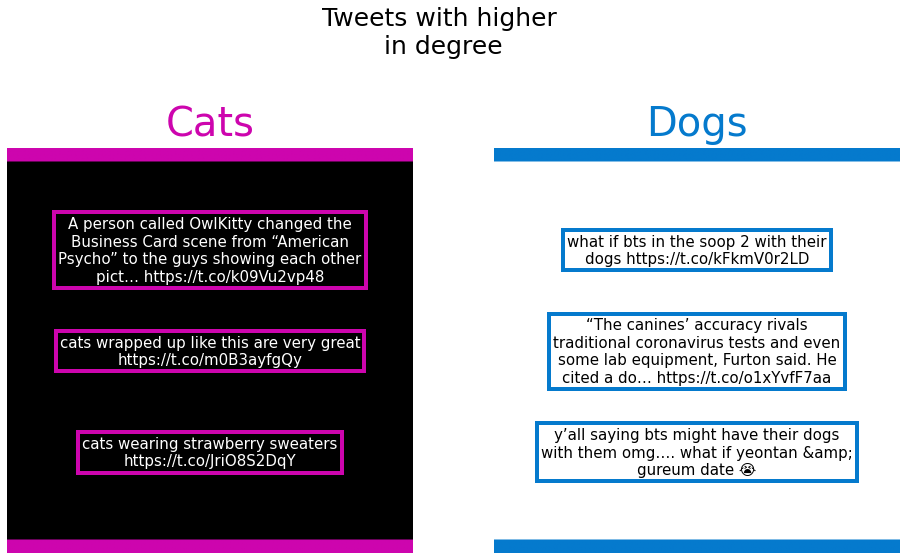

In [742]:
fig, ax = plt.subplots(ncols=2, figsize=(16,8))

plot_tweets(cats_top_tweets, ax[0], title='Cats',
            border_color=(205/255, 5/255, 174/255,1),
            word_color=(1,1,1,1),
            face_color=(0,0,0,1))

plot_tweets(dogs_top_tweets, ax[1], title='Dogs',
            border_color=(5/255, 122/255, 205/255, 1),
            word_color=(0,0,0,1),
            bg_color=(1,1,1,1))

fig.suptitle("Tweets with higher\n in degree", y=1.1, fontsize=25)

### Most common words in retweeted tweets

**Selecting retweeted tweets**


In [ ]:
cats_rt = df_cats.query('`in degree` > 0')
dogs_rt = df_dogs.query('`in degree` > 0')

**Building counter**

In [249]:
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True )
cnt_vec = CountVectorizer(max_features=500, stop_words=stopwords, tokenizer=tokenizer.tokenize)

In [250]:
cats_vec = cnt_vec.fit_transform( cats_rt['text_norm'] ).todense().sum(axis=0)
cats_vec_df = pd.DataFrame( cats_vec, columns=cnt_vec.get_feature_names() )

dogs_vec = cnt_vec.fit_transform( dogs_rt['text_norm'] ).todense().sum(axis=0)
dogs_vec_df = pd.DataFrame( dogs_vec, columns=cnt_vec.get_feature_names() )

**Selecting top frequent words**

In [835]:
def select_most_important_words_df( df, topn=10 ):
  return df.T.sort_values(by=0, ascending=False)[:topn]

# Reference
# https://stackoverflow.com/questions/27084617/detect-strings-with-non-english-characters-in-python
is_english = lambda s: s.isascii()
def filter_non_english_words(words):
  return [ w for w in words if is_english(w) ]

In [330]:
TOP_WORDS = 40
FINAL_TOP_WORDS = 10
cats_words = select_most_important_words_df(cats_vec_df, TOP_WORDS)
cats_words = list(cats_words.reset_index()['index'])
cats_words = filter_non_english_words(cats_words)[:FINAL_TOP_WORDS]

dogs_words = select_most_important_words_df(dogs_vec_df, TOP_WORDS)
dogs_words = list(dogs_words.reset_index()['index'])
dogs_words = filter_non_english_words(dogs_words)[:FINAL_TOP_WORDS]

**Showing Words**

https://gist.github.com/iktakahiro/aae1624918ac0a139144

In [721]:
def build_words_display(words, ax, 
                        bg_color=[0,0,0,1],
                        border_color=[1,1,1,1],
                        word_color=[1,1,1,1],
                        title='title'):
  margin_offset=8
  border_width=2
  height = 5*len(words)+2*margin_offset
  width = 50+1

  bg_img = np.zeros( (height, width, 4) )
  bg_img[:,:] = bg_color

  ## adding border
  bg_img[:border_width,:] = border_color
  bg_img[-border_width:,:] = border_color
  
  ax.imshow(bg_img)
  
  for i, y in enumerate( np.linspace(margin_offset, height-margin_offset, num=len(words)) ):
    ax.text(width//2, y, words[i], ha='center', va='center',
            color=word_color, fontdict={'size':30 } )
  ax.axis('off')

  ax.text(0.5, 1.01, title, transform=ax.transAxes, 
          color=word_color, ha='center', va='bottom', fontsize=40 )
  return

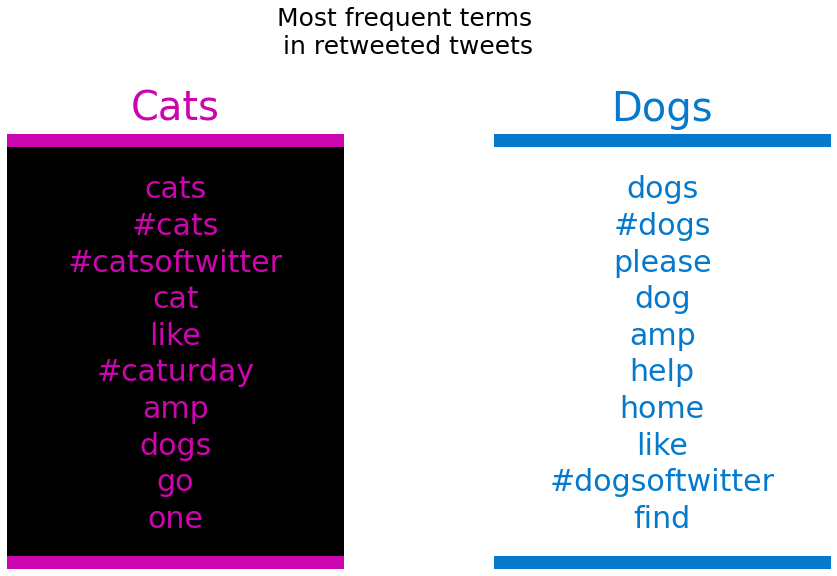

In [743]:
fig, ax = plt.subplots( ncols=2, figsize=(16,8) )
build_words_display(cats_words, ax[0], 
                    word_color=(205/255, 5/255, 174/255,1),
                    border_color=(205/255, 5/255, 174/255,1),
                    title='Cats'
                    )

build_words_display(dogs_words, ax[1], 
                    word_color=(5/255, 122/255, 205/255, 1),
                    border_color=(5/255, 122/255, 205/255, 1),
                    bg_color=(1,1,1,1),
                    title='Dogs'
                    )

fig.suptitle("Most frequent terms\n in retweeted tweets", fontsize=25, y=1.1)
fig.show()

### Building wordcloud with word frequency

In [826]:
from wordcloud import WordCloud, ImageColorGenerator
import PIL

In [824]:
def build_mask_bw(img):
  blacks = np.abs(img-np.array([0,0,0,255])).sum(axis=2)==0
  whites = np.abs(img-np.array([255,255,255,255])).sum(axis=2)==0
  bow = np.logical_or( blacks, whites ).astype(np.int8)
  
  mask_colors = np.array([[0,0,0,255], [255,255,255,255] ])
  mask = mask_colors[ bow ]
  return mask

**Generating masks**

In [839]:
cat_img = np.array( PIL.Image.open('Cat_Img.png') )
dog_img = np.array( PIL.Image.open('Dog_Img.png') )

cat_mask = build_mask_bw(cat_img)
dog_mask = build_mask_bw(dog_img)

**Generate word clouds**

In [837]:
TOP_WORDS=500
cats_words = select_most_important_words_df(cats_vec_df, TOP_WORDS)
cats_words = cats_words.to_dict()[0]
cats_words = {w:v for w,v in cats_words.items() if is_english(w) }

dogs_words = select_most_important_words_df(dogs_vec_df, TOP_WORDS)
dogs_words = dogs_words.to_dict()[0]
dogs_words = {w:v for w,v in dogs_words.items() if is_english(w) }

In [880]:
geral_params = dict(width=400, height=400, max_words=1000, repeat=True,
                    max_font_size=70, min_font_size=4)

wc_cats = WordCloud( **geral_params, mask=cat_mask)
wc_cats.generate_from_frequencies( cats_words )

wc_dogs = WordCloud(**geral_params, mask=dog_mask, background_color='white')
wc_dogs.generate_from_frequencies( dogs_words )

**Recoloring WordCloud**

In [ ]:
def recolor_cat(word, font_size, position, orientation, random_state=None, **kwargs):
  c = [205, 5, 174]
  return f"rgb({c[0]},{c[1]},{c[2]})"

def recolor_dog(word, font_size, position, orientation, random_state=None, **kwargs):
  c = [5, 122, 205]
  return f"rgb({c[0]},{c[1]},{c[2]})"

wc_cats.recolor( color_func=recolor_cat )
wc_dogs.recolor( color_func=recolor_dog )

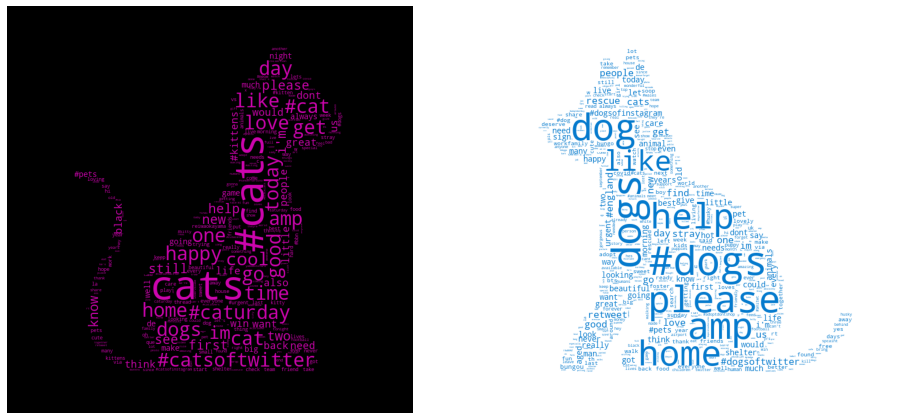

In [882]:
fig, ax = plt.subplots( ncols=2, figsize=(16,8) )
ax[0].imshow( wc_cats )
ax[0].axis('off')

ax[1].imshow( wc_dogs )
ax[1].axis('off')

fig.show()